# Desafío Data Scientist - LATAM Airlines

## 0. Introducción

Como parte del desafío LATAM se presenta una serie de problemas a responder a lo largo de este notebook en python 3. Para lo cual, se ha provisto de un archivo CSV con el dataset a usar y archivos vinculados a la solución (url: https://github.com/Mishagk/LATAM-Desafio-DS). 
<br><br>
Con todo esto, la principal problematica a responder o desarrollar es *"predecir la probabilidad de atraso de los vuelos que aterrizan o despegan del aeropuerto de Santiago de Chile (SCL)"*

## 1. Librerias

Previo a ejecutar este notebook se creará un entorno virtual en Anaconda (env name: latam1) en python **`3.9.13`**.
____
Esto se puede lograr en la terminal de Anaconda Prompt, colocando: `conda create -n latam1 python=3.9.13`

In [160]:
# Version de python en entorno virtual de Anaconda
!python --version

Python 3.9.13


NOTA: Es importante que se ejecute el código con la versión de python indicada ya que las librerias dependen del mismo

Se procede a instalar las principales librerias a utilizar

In [161]:
# Instalar principales librerias (NOTA: Algunas librerias tienen versiones especificas)

!pip install scikit-learn==1.1.3
!pip install numpy==1.23.4
!pip install pandas
!pip install scipy
!pip install seaborn
!pip install matplotlib

Con las librerias instaladas, se realiza la importación de las mismas

In [162]:
# Importar librerias

import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import re
import sys

import warnings
warnings.filterwarnings("ignore")  # Ignorar las advertencias, pero SI muestra los errores

# 2. Carga de Datos

In [163]:
# Leer datos desde la URL de github

# URL a github
url_github = "https://raw.githubusercontent.com/Mishagk/LATAM-Desafio-DS/master/dataset_SCL.csv"

# leer datos
data = pd.read_csv(url_github,sep=',',quotechar='"')

# ver primeras 5 filas
data.head()

,Fecha-I,Vlo-I,Ori-I,Des-I,Emp-I,Fecha-O,Vlo-O,Ori-O,Des-O,Emp-O,DIA,MES,AÑO,DIANOM,TIPOVUELO,OPERA,SIGLAORI,SIGLADES
0,2017-01-01 23:30:00,226,SCEL,KMIA,AAL,2017-01-01 23:33:00,226,SCEL,KMIA,AAL,1.0,1.0,2017.0,Domingo,I,American Airlines,Santiago,Miami
1,2017-01-02 23:30:00,226,SCEL,KMIA,AAL,2017-01-02 23:39:00,226,SCEL,KMIA,AAL,2.0,1.0,2017.0,Lunes,I,American Airlines,Santiago,Miami
2,2017-01-03 23:30:00,226,SCEL,KMIA,AAL,2017-01-03 23:39:00,226,SCEL,KMIA,AAL,3.0,1.0,2017.0,Martes,I,American Airlines,Santiago,Miami
3,2017-01-04 23:30:00,226,SCEL,KMIA,AAL,2017-01-04 23:33:00,226,SCEL,KMIA,AAL,4.0,1.0,2017.0,Miercoles,I,American Airlines,Santiago,Miami
4,2017-01-05 23:30:00,226,SCEL,KMIA,AAL,2017-01-05 23:28:00,226,SCEL,KMIA,AAL,5.0,1.0,2017.0,Jueves,I,American Airlines,Santiago,Miami


In [164]:
# informacion general de tabla

print('Cantidad columnas :',data.shape[1])
print('Cantidad registros:',data.shape[0])

Cantidad columnas : 18
Cantidad registros: 68206


El dataset leido contiene registro de los vuelos de aviones que aterrizaron o despegaron en Santiago de Chile (SCL). La descripción de cada variable:
<ul>
<li> Fecha-I : Fecha y hora programada del vuelo. (ordinal) </li>
<li> Vlo-I : Número de vuelo programado. (ordinal) </li>
<li> Ori-I : Código de ciudad de origen programado. (nominal) </li>
<li> Des-I : Código de ciudad de destino programado. (nominal) </li>
<li> Emp-I : Código aerolínea de vuelo programado. (nominal) </li>
<li> Fecha-O : Fecha y hora de operación del vuelo. (ordinal) </li>
<li> Vlo-O: Número de vuelo de operación del vuelo. (nominal) </li>
<li> Ori-O : Código de ciudad de origen de operación. (nominal) </li>
<li> Des-O : Código de ciudad de destino de operación. (nominal) </li>
<li> Emp-O : Código aerolínea de vuelo operado. (nominal) </li>
<li> DIA : Día del mes de operación del vuelo. (ordinal) </li>
<li> MES : Número de mes de operación del vuelo. (ordinal) </li>
<li> AÑO : Año de operación del vuelo. (ordinal) </li>
<li> DIANOM : Día de la semana de operación del vuelo. (ordinal) </li>
<li> TIPOVUELO : Tipo de vuelo, I =Internacional, N =Nacional. (nominal) </li>
<li> OPERA : Nombre de aerolínea que opera. (nominal) </li>
<li> SIGLAORI : Nombre ciudad origen. (nominal) </li>
<li> SIGLADES : Nombre ciudad destino. (nominal) </li>
</ul>

Es importante considerar que al lado derecho de cada una se colocó si se puede considerar del tipo **`ordinal`** o **`nominal`**. Esto significa que en caso de ser ordinal, poseen un orden entre los valores, por ejemplo los dias, el orden: es `lunes`, `martes`, `miercoles`, `jueves`, etc. Por el otro lado, variables nominales como aerolinea no poseen un orden natural, no se puede decir por ejemplo que `LAN` es mayor de `TAM` o `SUK` de forma natural.

## 3. Analisis y Preparación de Datos

### 3.1. Calidad de Datos

En esta sección revisaremos el estado de los datos en su condición de origen.

In [165]:
# Ver todas las columnas disponibles, la cantidad de datos nulos y el tipo de datos según se haya leido
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 68206 entries, 0 to 68205
Data columns (total 18 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Fecha-I    68206 non-null  object 
 1   Vlo-I      68167 non-null  object 
 2   Ori-I      68167 non-null  object 
 3   Des-I      68167 non-null  object 
 4   Emp-I      68167 non-null  object 
 5   Fecha-O    68167 non-null  object 
 6   Vlo-O      68166 non-null  object 
 7   Ori-O      68167 non-null  object 
 8   Des-O      68167 non-null  object 
 9   Emp-O      68167 non-null  object 
 10  DIA        68167 non-null  float64
 11  MES        68167 non-null  float64
 12  AÑO        68167 non-null  float64
 13  DIANOM     68167 non-null  object 
 14  TIPOVUELO  68167 non-null  object 
 15  OPERA      68167 non-null  object 
 16  SIGLAORI   68167 non-null  object 
 17  SIGLADES   68167 non-null  object 
dtypes: float64(3), object(15)
memory usage: 9.4+ MB


In [166]:
# Ver cuantos datos "vacios" o "nulos" se tienen desde informacion origen (data raw)
data.isnull().sum()

Fecha-I       0
Vlo-I        39
Ori-I        39
Des-I        39
Emp-I        39
Fecha-O      39
Vlo-O        40
Ori-O        39
Des-O        39
Emp-O        39
DIA          39
MES          39
AÑO          39
DIANOM       39
TIPOVUELO    39
OPERA        39
SIGLAORI     39
SIGLADES     39
dtype: int64

Observamos que hay **39** registros con datos nulos en la mayoría de columnas, acontinuación veremos dichos casos:

In [167]:
# Revisar los casos que poseen al menos 1 dato NaN en el registro
data_nan = data[data.isnull().any(axis=1)].copy()

# Datos sin NaN - La data con datos completos
data_com = data[~data.index.isin(data_nan.index)].copy()

# info
print('Cantidad de registros completos:',data_com.shape[0])
print('Cantidad de registros con algun NAN:',data_nan.shape[0])

# ver datos con NaN
data_nan.head()

Cantidad de registros completos: 68166
Cantidad de registros con algun NAN: 40


,Fecha-I,Vlo-I,Ori-I,Des-I,Emp-I,Fecha-O,Vlo-O,Ori-O,Des-O,Emp-O,DIA,MES,AÑO,DIANOM,TIPOVUELO,OPERA,SIGLAORI,SIGLADES
6068,2017-01-19 11:00:00,200,SCEL,SPJC,LAW,2017-01-19 11:03:00,NaN,SCEL,SPJC,56R,19.0,1.0,2017.0,Jueves,I,Latin American Wings,Santiago,Lima
17059,"2017-03-08 06:20:00,1351,SCEL,SBCT,LAN,2017-03...",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
17060,"2017-03-06 14:20:00,1357,SCEL,SBCT,LAN,2017-03...",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
39316,"2017-08-10 20:15:00,8541,SCEL,SBCT,ONE,2017-08...",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
55332,"2017-10-03 08:00:00,7896,SCEL,SANU,LAN,2017-10...",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


Segun los datos extraidos se observa que estos 39 casos, al leerse mediante pd.read_csv(), no logró interpretar las 18 columnas, sino que lo leyó como un unico valor en texto.

In [168]:
# Ver un caso de la mala lectura
data_nan.iloc[1,0] # seleccionar fila 1, columna 0

'2017-03-08 06:20:00,1351,SCEL,SBCT,LAN,2017-03-08 06:10:00,1351,SCEL,SBCT,LAN,8,3,2017,Miercoles,I,Grupo LATAM,Santiago,"Curitiba, Bra."'

Al observarse ese registro, al final esta el texto **"Curitiba, Bra."**. Con esto podemos inferir que la coma (`","`) entre `Curitiba` y `Bra.` posiblemente fue el que generó este error de lectura, dado que interpretó como 19 columnas en vez de 18.
<br><br>
Dada la lógica detectada, se hará un pequeño codigo que permita convertir la coma (`,`) a guion (`-`) con el fin de corregir estos casos. Esto se podría corregir desde el archivo origen al crear un csv con separador tipo `";"` para resolverlo. En el presente desarrollo, se usarán los datos según fueron provistos, sin alterar el archivo CSV origen.
<br><br>
NOTA: En caso de aplicar lo último, el codigo de lectura de datos cambiaría a: `pd.read_csv(url_github,sep=';')`

In [169]:
# Script de corrección y separación de valores

# leemos fila por fila de los datos extraidos
for i in range(data_nan.shape[0]):
    
    # Solo aquellas filas que posean NaN en todas excepto la primera columna NaN
    if(data_nan.iloc[i,:].isnull().sum() == 17):
        
        # extraer sub-cadena entre ""
        subtext = re.search('"(.*)"',data_nan.iloc[i,0]).group(1)
        
        # Corregir la subcadena de texto mediante el reemplazo de caracteres
        subtext_new = subtext.replace(",","-").replace("- ","-")
        texto = data_nan.iloc[i,0].replace(subtext,subtext_new).replace('"','') # Reemplazar texto completo
        
         # dividir en los valores de las columnas
        lista_valores = texto.split(",")
        
        # En caso en la lista obtenida existan 18 valores se actualiza
        if(len(lista_valores) == 18):
            data_nan.iloc[i,:] = lista_valores

# Lista valores unicos con casos detectados
print("Lista de valores en SIGLADES corregidos: ",data_nan.iloc[1:,:]["SIGLADES"].unique().tolist())

# ver valores corregidos
data_nan.head()

Lista de valores en SIGLADES corregidos:  ['Curitiba-Bra.', 'San Juan-Arg.', 'Pisco-Peru']


,Fecha-I,Vlo-I,Ori-I,Des-I,Emp-I,Fecha-O,Vlo-O,Ori-O,Des-O,Emp-O,DIA,MES,AÑO,DIANOM,TIPOVUELO,OPERA,SIGLAORI,SIGLADES
6068,2017-01-19 11:00:00,200,SCEL,SPJC,LAW,2017-01-19 11:03:00,NaN,SCEL,SPJC,56R,19.0,1.0,2017.0,Jueves,I,Latin American Wings,Santiago,Lima
17059,2017-03-08 06:20:00,1351,SCEL,SBCT,LAN,2017-03-08 06:10:00,1351,SCEL,SBCT,LAN,8,3,2017,Miercoles,I,Grupo LATAM,Santiago,Curitiba-Bra.
17060,2017-03-06 14:20:00,1357,SCEL,SBCT,LAN,2017-03-06 14:26:00,1357,SCEL,SBCT,LAN,6,3,2017,Lunes,I,Grupo LATAM,Santiago,Curitiba-Bra.
39316,2017-08-10 20:15:00,8541,SCEL,SBCT,ONE,2017-08-10 20:11:00,8541,SCEL,SBCT,ONE,10,8,2017,Jueves,I,Oceanair Linhas Aereas,Santiago,Curitiba-Bra.
55332,2017-10-03 08:00:00,7896,SCEL,SANU,LAN,2017-10-03 08:00:00,7896,SCEL,SANU,DSM,3,10,2017,Martes,I,Grupo LATAM,Santiago,San Juan-Arg.


Solo para validar que efectivamente estos valores de texto son unicos y no hay otras ciudades iguales que no fueron afectadas.

In [170]:
# [1] Seleccionar datos del dataframe con NaN corregido
data_nan[(data_nan["SIGLADES"].str.contains("Curitiba",regex=0,na=0)) |
     (data_nan["SIGLADES"].str.contains("San Juan",regex=0,na=0)) |
     (data_nan["SIGLADES"].str.contains("Pisco",regex=0,na=0))].head()

,Fecha-I,Vlo-I,Ori-I,Des-I,Emp-I,Fecha-O,Vlo-O,Ori-O,Des-O,Emp-O,DIA,MES,AÑO,DIANOM,TIPOVUELO,OPERA,SIGLAORI,SIGLADES
17059,2017-03-08 06:20:00,1351,SCEL,SBCT,LAN,2017-03-08 06:10:00,1351,SCEL,SBCT,LAN,8,3,2017,Miercoles,I,Grupo LATAM,Santiago,Curitiba-Bra.
17060,2017-03-06 14:20:00,1357,SCEL,SBCT,LAN,2017-03-06 14:26:00,1357,SCEL,SBCT,LAN,6,3,2017,Lunes,I,Grupo LATAM,Santiago,Curitiba-Bra.
39316,2017-08-10 20:15:00,8541,SCEL,SBCT,ONE,2017-08-10 20:11:00,8541,SCEL,SBCT,ONE,10,8,2017,Jueves,I,Oceanair Linhas Aereas,Santiago,Curitiba-Bra.
55332,2017-10-03 08:00:00,7896,SCEL,SANU,LAN,2017-10-03 08:00:00,7896,SCEL,SANU,DSM,3,10,2017,Martes,I,Grupo LATAM,Santiago,San Juan-Arg.
55333,2017-10-05 08:00:00,7896,SCEL,SANU,LAN,2017-10-05 07:59:00,7896,SCEL,SANU,DSM,5,10,2017,Jueves,I,Grupo LATAM,Santiago,San Juan-Arg.


In [171]:
# [2] Seleccionar datos del dataframe completo
data_com[(data_com["SIGLADES"].str.contains("Curitiba",regex=0,na=0)) |
     (data_com["SIGLADES"].str.contains("San Juan",regex=0,na=0)) |
     (data_com["SIGLADES"].str.contains("Pisco",regex=0,na=0))].head()

,Fecha-I,Vlo-I,Ori-I,Des-I,Emp-I,Fecha-O,Vlo-O,Ori-O,Des-O,Emp-O,DIA,MES,AÑO,DIANOM,TIPOVUELO,OPERA,SIGLAORI,SIGLADES


Vemos que en **[2]** no se encontró ningun valor (numero filas=0) en la columna `SIGLADES` que tuviese las mismas palabras iniciales que de los 39 registros corregidos (`"Curitiba"`,`"San Juan"`,`"Pisco"`), por lo que esta corrección no va afectar a otros registros. <br>(*Ejemplo*: Caso de valor `"Curitiba-Bra"` y otro `"Curitiba;Bra"`, en si ambos corresponden al mismo. Pero no va ocurrir segun vemos)

In [172]:
# Obtener un dataframe consolidado entre los dataframes completos y NaN corregidos. Adicional, ver la cantidad de registros nulos

try:
    # Concatenar ambos dataframes
    data = pd.concat([data_com.copy(),data_nan.copy()])

    # Borramos de memoria los anteriores
    del data_com, data_nan
    
except:
    print('[Info Advertencia] Se borraron previamente los dataframes')

# info
print('Cantidad de registros al concatenar dataframes:',data.shape[0])
print('--------------------------------------------------------')

# Revisamos nuevamente los datos nulos en la nueva data
print('Cantidad de datos NaN por variable:')
data.isnull().sum()

Cantidad de registros al concatenar dataframes: 68206
--------------------------------------------------------
Cantidad de datos NaN por variable:


Fecha-I      0
Vlo-I        0
Ori-I        0
Des-I        0
Emp-I        0
Fecha-O      0
Vlo-O        1
Ori-O        0
Des-O        0
Emp-O        0
DIA          0
MES          0
AÑO          0
DIANOM       0
TIPOVUELO    0
OPERA        0
SIGLAORI     0
SIGLADES     0
dtype: int64

Observamos que solo hay **1** registro con NaN, donde el campo faltante es el **número de vuelo de operación** (`Vlo-O`)

In [173]:
data[data.isnull().any(axis=1)].copy()

,Fecha-I,Vlo-I,Ori-I,Des-I,Emp-I,Fecha-O,Vlo-O,Ori-O,Des-O,Emp-O,DIA,MES,AÑO,DIANOM,TIPOVUELO,OPERA,SIGLAORI,SIGLADES
6068,2017-01-19 11:00:00,200,SCEL,SPJC,LAW,2017-01-19 11:03:00,NaN,SCEL,SPJC,56R,19.0,1.0,2017.0,Jueves,I,Latin American Wings,Santiago,Lima


Solo para ver si podemos completar el dato faltante, filtramos aquellos registros con columnas comunes como `Emp-I`,`Emp-O` y `OPERA`

In [174]:
data[(data["Emp-I"]=="LAW") &
     (data["Emp-O"]=="56R") & 
     (data["OPERA"]=="Latin American Wings")].sort_values(by=["Fecha-I","Vlo-I","Ori-I","Des-I","Emp-I"])

,Fecha-I,Vlo-I,Ori-I,Des-I,Emp-I,Fecha-O,Vlo-O,Ori-O,Des-O,Emp-O,DIA,MES,AÑO,DIANOM,TIPOVUELO,OPERA,SIGLAORI,SIGLADES
6094,2017-01-02 01:15:00,704,SCEL,SPJC,LAW,2017-01-02 01:34:00,704,SCEL,SPJC,56R,2.0,1.0,2017.0,Lunes,I,Latin American Wings,Santiago,Lima
6107,2017-01-03 01:15:00,1704,SCEL,SPJC,LAW,2017-01-03 02:38:00,1700,SCEL,SPJC,56R,3.0,1.0,2017.0,Martes,I,Latin American Wings,Santiago,Lima
6079,2017-01-04 01:15:00,700,SCEL,SPJC,LAW,2017-01-04 02:25:00,700,SCEL,SPJC,56R,4.0,1.0,2017.0,Miercoles,I,Latin American Wings,Santiago,Lima
6095,2017-01-05 01:15:00,704,SCEL,SPJC,LAW,2017-01-05 01:15:00,708,SCEL,SPJC,56R,5.0,1.0,2017.0,Jueves,I,Latin American Wings,Santiago,Lima
6080,2017-01-06 01:15:00,700,SCEL,SPJC,LAW,2017-01-06 02:18:00,700,SCEL,SPJC,56R,6.0,1.0,2017.0,Viernes,I,Latin American Wings,Santiago,Lima
6082,2017-01-08 01:15:00,700,SCEL,SPJC,LAW,2017-01-08 02:01:00,700,SCEL,SPJC,56R,8.0,1.0,2017.0,Domingo,I,Latin American Wings,Santiago,Lima
6096,2017-01-09 01:15:00,704,SCEL,SPJC,LAW,2017-01-09 02:15:00,704,SCEL,SPJC,56R,9.0,1.0,2017.0,Lunes,I,Latin American Wings,Santiago,Lima
6097,2017-01-10 01:15:00,704,SCEL,SPJC,LAW,2017-01-10 02:36:00,704,SCEL,SPJC,56R,10.0,1.0,2017.0,Martes,I,Latin American Wings,Santiago,Lima
6083,2017-01-11 01:15:00,700,SCEL,SPJC,LAW,2017-01-11 01:20:00,700,SCEL,SPJC,56R,11.0,1.0,2017.0,Miercoles,I,Latin American Wings,Santiago,Lima
6098,2017-01-12 01:15:00,704,SCEL,SPJC,LAW,2017-01-12 01:55:00,702,SCEL,SPJC,56R,12.0,1.0,2017.0,Jueves,I,Latin American Wings,Santiago,Lima


Observamos la ultima fila, el registro con el dato `NaN`, hay 2 vuelos para la fecha del 2017-01-19 (`Fecha_I`). Debido a que hay casos donde el `Vlo-I` no es igual a `Vlo-O`, no podriamos inferir necesariamente que `Vlo-O` para dicho caso tenga que ser valor **200**.
<br><br>
Para validar esto, podemos revisar aquellos casos donde se tuvo valor de `Vlo-I`=200 para ver si podria o no darse otro valor igual en `Vlo-O`

In [175]:
# Extraer valores 200 excepto aquellos registros con algun NaN
valida_Vlo = data[(data["Vlo-I"]=="200") & (~data.isnull().any(axis=1))][["Vlo-I","Vlo-O"]].copy()

# crear el par de valores existentes "Vlo-I_Vlo-O"
valida_Vlo["par"] = valida_Vlo["Vlo-I"].map(str) + "_" + valida_Vlo["Vlo-O"].map(str)

# Ver lista con valores encontrados
valida_Vlo["par"].unique().tolist()

['200_200']

Mediante esto vemos que todos aquellos vuelos registrados que tienen valor de **200** en `Vlo-I` también tienen ese valor en `Vlo-O`. Por lo que con mayor confianza podemos asignar este valor al dato faltante.

In [176]:
# Actualizar registro con dato faltante
indice_corrige = data[data.isnull().any(axis=1)].index

# Corrige - Coloca valor de forma manual
data.loc[indice_corrige,"Vlo-O"] = "200"

# ver dato corregido
data.loc[indice_corrige,:]

,Fecha-I,Vlo-I,Ori-I,Des-I,Emp-I,Fecha-O,Vlo-O,Ori-O,Des-O,Emp-O,DIA,MES,AÑO,DIANOM,TIPOVUELO,OPERA,SIGLAORI,SIGLADES
6068,2017-01-19 11:00:00,200,SCEL,SPJC,LAW,2017-01-19 11:03:00,200,SCEL,SPJC,56R,19.0,1.0,2017.0,Jueves,I,Latin American Wings,Santiago,Lima


### 3.2. Formateo y limpieza de datos

Mediante la observación a priori de los datos y usando la descripción del diccionario de cada variable se realizará el formateo de cada una.

In [177]:
# Creamos un backup previo al formateo de datos, para evaluar los casos donde el formato generará NaN por error
data_bkp = data.copy()

In [178]:
# Convertir de formato segun cada columna

# fecha
data["Fecha-I"] = pd.to_datetime(data["Fecha-I"],format="%Y-%m-%d %H:%M:%S")
data["Fecha-O"] = pd.to_datetime(data["Fecha-O"],format="%Y-%m-%d %H:%M:%S") 

# entero
data["Vlo-I"] = pd.to_numeric(data["Vlo-I"], errors="coerce",downcast="integer") 
data["Vlo-O"] = pd.to_numeric(data["Vlo-O"], errors="coerce",downcast="integer")

# texto
data["Ori-I"] = data["Ori-I"].map(str) 
data["Des-I"] = data["Des-I"].map(str) 
data["Emp-I"] = data["Emp-I"].map(str) 
data["Ori-O"] = data["Ori-O"].map(str) 
data["Des-O"] = data["Des-O"].map(str) 
data["Emp-O"] = data["Emp-O"].map(str)

# entero
data["DIA"] = pd.to_numeric(data["DIA"], errors="coerce",downcast="integer")
data["MES"] = pd.to_numeric(data["MES"], errors="coerce",downcast="integer")
data["AÑO"] = pd.to_numeric(data["AÑO"], errors="coerce",downcast="integer")

# texto
data["DIANOM"] = data["DIANOM"].map(str) 
data["TIPOVUELO"] = data["TIPOVUELO"].map(str) 
data["OPERA"] = data["OPERA"].map(str)
data["SIGLAORI"] = data["SIGLAORI"].map(str) 
data["SIGLADES"] = data["SIGLADES"].map(str)

# Ver tipo de datos de salida
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 68206 entries, 0 to 67669
Data columns (total 18 columns):
 #   Column     Non-Null Count  Dtype         
---  ------     --------------  -----         
 0   Fecha-I    68206 non-null  datetime64[ns]
 1   Vlo-I      68201 non-null  float64       
 2   Ori-I      68206 non-null  object        
 3   Des-I      68206 non-null  object        
 4   Emp-I      68206 non-null  object        
 5   Fecha-O    68206 non-null  datetime64[ns]
 6   Vlo-O      68190 non-null  float64       
 7   Ori-O      68206 non-null  object        
 8   Des-O      68206 non-null  object        
 9   Emp-O      68206 non-null  object        
 10  DIA        68206 non-null  int8          
 11  MES        68206 non-null  int8          
 12  AÑO        68206 non-null  int16         
 13  DIANOM     68206 non-null  object        
 14  TIPOVUELO  68206 non-null  object        
 15  OPERA      68206 non-null  object        
 16  SIGLAORI   68206 non-null  object       

In [179]:
# ver datos formateados
data.head()

,Fecha-I,Vlo-I,Ori-I,Des-I,Emp-I,Fecha-O,Vlo-O,Ori-O,Des-O,Emp-O,DIA,MES,AÑO,DIANOM,TIPOVUELO,OPERA,SIGLAORI,SIGLADES
0,2017-01-01 23:30:00,226.0,SCEL,KMIA,AAL,2017-01-01 23:33:00,226.0,SCEL,KMIA,AAL,1,1,2017,Domingo,I,American Airlines,Santiago,Miami
1,2017-01-02 23:30:00,226.0,SCEL,KMIA,AAL,2017-01-02 23:39:00,226.0,SCEL,KMIA,AAL,2,1,2017,Lunes,I,American Airlines,Santiago,Miami
2,2017-01-03 23:30:00,226.0,SCEL,KMIA,AAL,2017-01-03 23:39:00,226.0,SCEL,KMIA,AAL,3,1,2017,Martes,I,American Airlines,Santiago,Miami
3,2017-01-04 23:30:00,226.0,SCEL,KMIA,AAL,2017-01-04 23:33:00,226.0,SCEL,KMIA,AAL,4,1,2017,Miercoles,I,American Airlines,Santiago,Miami
4,2017-01-05 23:30:00,226.0,SCEL,KMIA,AAL,2017-01-05 23:28:00,226.0,SCEL,KMIA,AAL,5,1,2017,Jueves,I,American Airlines,Santiago,Miami


In [180]:
# Datos que al formatear no se pudo y se cambiaron a NaN
data[data.isnull().any(axis=1)].copy().head(8)

,Fecha-I,Vlo-I,Ori-I,Des-I,Emp-I,Fecha-O,Vlo-O,Ori-O,Des-O,Emp-O,DIA,MES,AÑO,DIANOM,TIPOVUELO,OPERA,SIGLAORI,SIGLADES
13906,2017-03-30 10:30:00,71.0,SCEL,SCIE,SKU,2017-03-30 10:50:00,NaN,SCEL,SCIE,SKU,30,3,2017,Jueves,N,Sky Airline,Santiago,Concepcion
13907,2017-03-22 11:00:00,1071.0,SCEL,SCIE,SKU,2017-03-22 11:00:00,NaN,SCEL,SCIE,SKU,22,3,2017,Miercoles,N,Sky Airline,Santiago,Concepcion
17055,2017-03-22 10:00:00,201.0,SCEL,SCIE,LXP,2017-03-22 11:50:00,NaN,SCEL,SCIE,LXP,22,3,2017,Miercoles,N,Grupo LATAM,Santiago,Concepcion
19207,2017-04-25 09:00:00,71.0,SCEL,SCIE,SKU,2017-04-25 09:29:00,NaN,SCEL,SCIE,SKU,25,4,2017,Martes,N,Sky Airline,Santiago,Concepcion
22167,2017-04-06 21:10:00,43.0,SCEL,SCIE,LAW,2017-04-06 21:24:00,NaN,SCEL,SCIE,JMR,6,4,2017,Jueves,N,Latin American Wings,Santiago,Concepcion
22232,2017-05-13 21:50:00,NaN,SCEL,SUMU,AAL,2017-05-13 21:52:00,989.0,SCEL,SUMU,AAL,13,5,2017,Sabado,I,American Airlines,Santiago,Montevideo
22301,2017-05-26 09:40:00,401.0,SCEL,LFPG,AFR,2017-05-26 10:03:00,NaN,SCEL,LFPG,AFR,26,5,2017,Viernes,I,Air France,Santiago,Paris
22302,2017-05-28 09:40:00,401.0,SCEL,LFPG,AFR,2017-05-28 09:43:00,NaN,SCEL,LFPG,AFR,28,5,2017,Domingo,I,Air France,Santiago,Paris


In [181]:
# De los datos backup vemos los valores previos al formateo
indice_lee = data[data.isnull().any(axis=1)].index
data_bkp[data_bkp.index.isin(indice_lee)].head(8)

,Fecha-I,Vlo-I,Ori-I,Des-I,Emp-I,Fecha-O,Vlo-O,Ori-O,Des-O,Emp-O,DIA,MES,AÑO,DIANOM,TIPOVUELO,OPERA,SIGLAORI,SIGLADES
13906,2017-03-30 10:30:00,71,SCEL,SCIE,SKU,2017-03-30 10:50:00,71R,SCEL,SCIE,SKU,30.0,3.0,2017.0,Jueves,N,Sky Airline,Santiago,Concepcion
13907,2017-03-22 11:00:00,1071,SCEL,SCIE,SKU,2017-03-22 11:00:00,71R,SCEL,SCIE,SKU,22.0,3.0,2017.0,Miercoles,N,Sky Airline,Santiago,Concepcion
17055,2017-03-22 10:00:00,201,SCEL,SCIE,LXP,2017-03-22 11:50:00,201R,SCEL,SCIE,LXP,22.0,3.0,2017.0,Miercoles,N,Grupo LATAM,Santiago,Concepcion
19207,2017-04-25 09:00:00,71,SCEL,SCIE,SKU,2017-04-25 09:29:00,71R,SCEL,SCIE,SKU,25.0,4.0,2017.0,Martes,N,Sky Airline,Santiago,Concepcion
22167,2017-04-06 21:10:00,43,SCEL,SCIE,LAW,2017-04-06 21:24:00,43R,SCEL,SCIE,JMR,6.0,4.0,2017.0,Jueves,N,Latin American Wings,Santiago,Concepcion
22232,2017-05-13 21:50:00,989P,SCEL,SUMU,AAL,2017-05-13 21:52:00,989,SCEL,SUMU,AAL,13.0,5.0,2017.0,Sabado,I,American Airlines,Santiago,Montevideo
22301,2017-05-26 09:40:00,401,SCEL,LFPG,AFR,2017-05-26 10:03:00,401A,SCEL,LFPG,AFR,26.0,5.0,2017.0,Viernes,I,Air France,Santiago,Paris
22302,2017-05-28 09:40:00,401,SCEL,LFPG,AFR,2017-05-28 09:43:00,401B,SCEL,LFPG,AFR,28.0,5.0,2017.0,Domingo,I,Air France,Santiago,Paris


Con lo anterior, evidenciamos que las columnas `Vlo-I` y `Vlo-O` hay algunos valores que poseen una letra al final (`A`,`R`,`P`). Esto desde el negocio podría tener un significado específico pero dado que el diccionario nos indica que estos deberían ser numericos y en vista de que son una gran minoría de datos, se extraerán las letras finales.

In [182]:
# Aplicar backup
data = data_bkp.copy() # restaurar valores previos

# Extraer solo los caracteres numericos y filtrar las letras
data["Vlo-I"] = data["Vlo-I"].map(str).str.extract('([0-9]*)')
data["Vlo-O"] = data["Vlo-O"].map(str).str.extract('([0-9]*)')

# Ver los datos donde se realizaro la correccion
data[data_bkp.index.isin(indice_lee)].head(8)

,Fecha-I,Vlo-I,Ori-I,Des-I,Emp-I,Fecha-O,Vlo-O,Ori-O,Des-O,Emp-O,DIA,MES,AÑO,DIANOM,TIPOVUELO,OPERA,SIGLAORI,SIGLADES
13906,2017-03-30 10:30:00,71,SCEL,SCIE,SKU,2017-03-30 10:50:00,71,SCEL,SCIE,SKU,30.0,3.0,2017.0,Jueves,N,Sky Airline,Santiago,Concepcion
13907,2017-03-22 11:00:00,1071,SCEL,SCIE,SKU,2017-03-22 11:00:00,71,SCEL,SCIE,SKU,22.0,3.0,2017.0,Miercoles,N,Sky Airline,Santiago,Concepcion
17055,2017-03-22 10:00:00,201,SCEL,SCIE,LXP,2017-03-22 11:50:00,201,SCEL,SCIE,LXP,22.0,3.0,2017.0,Miercoles,N,Grupo LATAM,Santiago,Concepcion
19207,2017-04-25 09:00:00,71,SCEL,SCIE,SKU,2017-04-25 09:29:00,71,SCEL,SCIE,SKU,25.0,4.0,2017.0,Martes,N,Sky Airline,Santiago,Concepcion
22167,2017-04-06 21:10:00,43,SCEL,SCIE,LAW,2017-04-06 21:24:00,43,SCEL,SCIE,JMR,6.0,4.0,2017.0,Jueves,N,Latin American Wings,Santiago,Concepcion
22232,2017-05-13 21:50:00,989,SCEL,SUMU,AAL,2017-05-13 21:52:00,989,SCEL,SUMU,AAL,13.0,5.0,2017.0,Sabado,I,American Airlines,Santiago,Montevideo
22301,2017-05-26 09:40:00,401,SCEL,LFPG,AFR,2017-05-26 10:03:00,401,SCEL,LFPG,AFR,26.0,5.0,2017.0,Viernes,I,Air France,Santiago,Paris
22302,2017-05-28 09:40:00,401,SCEL,LFPG,AFR,2017-05-28 09:43:00,401,SCEL,LFPG,AFR,28.0,5.0,2017.0,Domingo,I,Air France,Santiago,Paris


In [183]:
# Convertir de formato segun cada columna

# fecha
data["Fecha-I"] = pd.to_datetime(data["Fecha-I"],format="%Y-%m-%d %H:%M:%S")
data["Fecha-O"] = pd.to_datetime(data["Fecha-O"],format="%Y-%m-%d %H:%M:%S") 

# entero
data["Vlo-I"] = pd.to_numeric(data["Vlo-I"], errors="coerce",downcast="integer") 
data["Vlo-O"] = pd.to_numeric(data["Vlo-O"], errors="coerce",downcast="integer")

# texto
data["Ori-I"] = data["Ori-I"].map(str) 
data["Des-I"] = data["Des-I"].map(str) 
data["Emp-I"] = data["Emp-I"].map(str) 
data["Ori-O"] = data["Ori-O"].map(str) 
data["Des-O"] = data["Des-O"].map(str) 
data["Emp-O"] = data["Emp-O"].map(str)

# entero
data["DIA"] = pd.to_numeric(data["DIA"], errors="coerce",downcast="integer")
data["MES"] = pd.to_numeric(data["MES"], errors="coerce",downcast="integer")
data["AÑO"] = pd.to_numeric(data["AÑO"], errors="coerce",downcast="integer")

# texto
data["DIANOM"] = data["DIANOM"].map(str) 
data["TIPOVUELO"] = data["TIPOVUELO"].map(str) 
data["OPERA"] = data["OPERA"].map(str)
data["SIGLAORI"] = data["SIGLAORI"].map(str) 
data["SIGLADES"] = data["SIGLADES"].map(str)

# Ver tipo de datos de salida
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 68206 entries, 0 to 67669
Data columns (total 18 columns):
 #   Column     Non-Null Count  Dtype         
---  ------     --------------  -----         
 0   Fecha-I    68206 non-null  datetime64[ns]
 1   Vlo-I      68206 non-null  int16         
 2   Ori-I      68206 non-null  object        
 3   Des-I      68206 non-null  object        
 4   Emp-I      68206 non-null  object        
 5   Fecha-O    68206 non-null  datetime64[ns]
 6   Vlo-O      68206 non-null  int16         
 7   Ori-O      68206 non-null  object        
 8   Des-O      68206 non-null  object        
 9   Emp-O      68206 non-null  object        
 10  DIA        68206 non-null  int8          
 11  MES        68206 non-null  int8          
 12  AÑO        68206 non-null  int16         
 13  DIANOM     68206 non-null  object        
 14  TIPOVUELO  68206 non-null  object        
 15  OPERA      68206 non-null  object        
 16  SIGLAORI   68206 non-null  object       

In [184]:
# ver datos
data.head()

,Fecha-I,Vlo-I,Ori-I,Des-I,Emp-I,Fecha-O,Vlo-O,Ori-O,Des-O,Emp-O,DIA,MES,AÑO,DIANOM,TIPOVUELO,OPERA,SIGLAORI,SIGLADES
0,2017-01-01 23:30:00,226,SCEL,KMIA,AAL,2017-01-01 23:33:00,226,SCEL,KMIA,AAL,1,1,2017,Domingo,I,American Airlines,Santiago,Miami
1,2017-01-02 23:30:00,226,SCEL,KMIA,AAL,2017-01-02 23:39:00,226,SCEL,KMIA,AAL,2,1,2017,Lunes,I,American Airlines,Santiago,Miami
2,2017-01-03 23:30:00,226,SCEL,KMIA,AAL,2017-01-03 23:39:00,226,SCEL,KMIA,AAL,3,1,2017,Martes,I,American Airlines,Santiago,Miami
3,2017-01-04 23:30:00,226,SCEL,KMIA,AAL,2017-01-04 23:33:00,226,SCEL,KMIA,AAL,4,1,2017,Miercoles,I,American Airlines,Santiago,Miami
4,2017-01-05 23:30:00,226,SCEL,KMIA,AAL,2017-01-05 23:28:00,226,SCEL,KMIA,AAL,5,1,2017,Jueves,I,American Airlines,Santiago,Miami


Si bien la columna del numero de mes nos permite ver esta variable como númerica, o en otra perspectiva del tipo categorica ordinal, dado que cada mes posee un orden en progresión. También se podría colocar el nombre del mes para mejor lectura del mismo.

In [185]:
# Crear variable nombre del mes

# diccionario con el mapeo de los valores
mes_dic = {
    1:"Enero",
    2:"Febrero",
    3:"Marzo",
    4:"Abril",
    5:"Mayo",
    6:"Junio",
    7:"Julio",
    8:"Agosto",
    9:"Setiembre",
    10:"Octubre",
    11:"Noviembre",
    12:"Diciembre"}

# Crear columna nueva con el nombre de los meses
data["MESNOM"] = data["MES"].apply(lambda x:mes_dic[x])
data.head()

,Fecha-I,Vlo-I,Ori-I,Des-I,Emp-I,Fecha-O,Vlo-O,Ori-O,Des-O,Emp-O,DIA,MES,AÑO,DIANOM,TIPOVUELO,OPERA,SIGLAORI,SIGLADES,MESNOM
0,2017-01-01 23:30:00,226,SCEL,KMIA,AAL,2017-01-01 23:33:00,226,SCEL,KMIA,AAL,1,1,2017,Domingo,I,American Airlines,Santiago,Miami,Enero
1,2017-01-02 23:30:00,226,SCEL,KMIA,AAL,2017-01-02 23:39:00,226,SCEL,KMIA,AAL,2,1,2017,Lunes,I,American Airlines,Santiago,Miami,Enero
2,2017-01-03 23:30:00,226,SCEL,KMIA,AAL,2017-01-03 23:39:00,226,SCEL,KMIA,AAL,3,1,2017,Martes,I,American Airlines,Santiago,Miami,Enero
3,2017-01-04 23:30:00,226,SCEL,KMIA,AAL,2017-01-04 23:33:00,226,SCEL,KMIA,AAL,4,1,2017,Miercoles,I,American Airlines,Santiago,Miami,Enero
4,2017-01-05 23:30:00,226,SCEL,KMIA,AAL,2017-01-05 23:28:00,226,SCEL,KMIA,AAL,5,1,2017,Jueves,I,American Airlines,Santiago,Miami,Enero


### 3.3. Exploración de variables

En este segmento analizaremos como estan distribuidas las variables. Además, esto permitirá seguir afinando la limpieza y perfilamiento de los datos.

<b>Variables Categoricas

In [186]:
# Ver descripcion general de variables categoricas
datacat = data.select_dtypes(include=["object"])
datacat.head(8)

,Ori-I,Des-I,Emp-I,Ori-O,Des-O,Emp-O,DIANOM,TIPOVUELO,OPERA,SIGLAORI,SIGLADES,MESNOM
0,SCEL,KMIA,AAL,SCEL,KMIA,AAL,Domingo,I,American Airlines,Santiago,Miami,Enero
1,SCEL,KMIA,AAL,SCEL,KMIA,AAL,Lunes,I,American Airlines,Santiago,Miami,Enero
2,SCEL,KMIA,AAL,SCEL,KMIA,AAL,Martes,I,American Airlines,Santiago,Miami,Enero
3,SCEL,KMIA,AAL,SCEL,KMIA,AAL,Miercoles,I,American Airlines,Santiago,Miami,Enero
4,SCEL,KMIA,AAL,SCEL,KMIA,AAL,Jueves,I,American Airlines,Santiago,Miami,Enero
5,SCEL,KMIA,AAL,SCEL,KMIA,AAL,Sabado,I,American Airlines,Santiago,Miami,Enero
6,SCEL,KMIA,AAL,SCEL,KMIA,AAL,Sabado,I,American Airlines,Santiago,Miami,Enero
7,SCEL,KMIA,AAL,SCEL,KMIA,AAL,Domingo,I,American Airlines,Santiago,Miami,Enero


In [187]:
# Descripcion general de los datos
datacat.describe()

,Ori-I,Des-I,Emp-I,Ori-O,Des-O,Emp-O,DIANOM,TIPOVUELO,OPERA,SIGLAORI,SIGLADES,MESNOM
count,68206,68206,68206,68206,68206,68206,68206,68206,68206,68206,68206,68206
unique,1,64,30,1,63,32,7,2,23,1,62,12
top,SCEL,SCFA,LAN,SCEL,SCFA,LAN,Viernes,N,Grupo LATAM,Santiago,Buenos Aires,Diciembre
freq,68206,5787,37611,68206,5786,20988,10292,36966,40892,68206,6335,6356


Dado que el objetivo es predecir los vuelos que aterrizan o despegan del aeropuerto de Santiago de Chile (SCL), es importante entender que proporción de vuelos tenemos que despegan y aterrizan en SCL.

In [188]:
# Ver valores segun Nombre de ciudad Origen
datacat[["SIGLAORI"]].value_counts()

SIGLAORI
Santiago    68206
dtype: int64

Segun esto vemos que el **`100%`** de los registros son de vuelos que **despegan** en SCL, por lo que esperariamos que según vuelos *"regulares"* no deberían aterrizan en SCL. No es regular que el destino sea igual al origen. Esto lo validamos con la variable `SIGLADES`:

In [189]:
# Extraer las ciudades de Destino que tengan a Santiago de Chile como punto de aterrizaje
data[(data["SIGLADES"].str.contains("Santia",regex=0,na=0)) | 
     (data["SIGLADES"].str.contains("SANTIA",regex=0,na=0))]

,Fecha-I,Vlo-I,Ori-I,Des-I,Emp-I,Fecha-O,Vlo-O,Ori-O,Des-O,Emp-O,DIA,MES,AÑO,DIANOM,TIPOVUELO,OPERA,SIGLAORI,SIGLADES,MESNOM


*Observación*: Con esto se corrobora que los datos disponibles solo corresponden a vuelos que despegan en **Santiago de Chile**. Por lo que el objetivo es predecir el retraso para los vuelos que despegan en Santiago de Chile

---------------------------------------------------
Variable:  TIPOVUELO
Cantidad de registros por valor:
  TIPOVUELO  cantidad  Porc.%  Acum.%
0         N     36966    54.2    54.2
1         I     31240    45.8   100.0
---------------------------------------------------
Variable:  Ori-I
Cantidad de registros por valor:
  Ori-I  cantidad  Porc.%  Acum.%
0  SCEL     68206   100.0   100.0
---------------------------------------------------
Variable:  Ori-O
Cantidad de registros por valor:
  Ori-O  cantidad  Porc.%  Acum.%
0  SCEL     68206   100.0   100.0
---------------------------------------------------
Variable:  SIGLAORI
Cantidad de registros por valor:
   SIGLAORI  cantidad  Porc.%  Acum.%
0  Santiago     68206   100.0   100.0
---------------------------------------------------
Variable:  Des-I
Valores con mas registros:
  Des-I  cantidad  Porc.%  Acum.%
0  SCFA      5787    8.48    8.48
1  SPJC      5270    7.73   16.21
2  SCCF      5145    7.54   23.75
3  SCTE      4357    6.39  

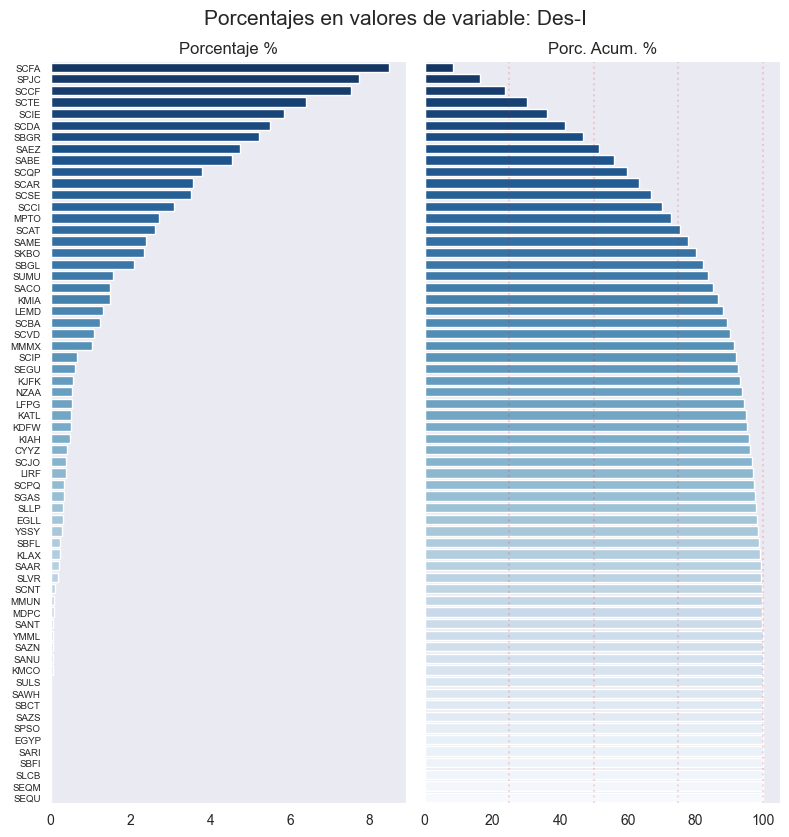

---------------------------------------------------
Variable:  Des-O
Valores con mas registros:
  Des-O  cantidad  Porc.%  Acum.%
0  SCFA      5786    8.48    8.48
1  SPJC      5270    7.73   16.22
2  SCCF      5146    7.54   23.76
3  SCTE      4357    6.39   30.15
4  SCIE      3993    5.85   36.00
5  SCDA      3747    5.49   41.50
Valores con menos registros:
   Des-O  cantidad  Porc.%  Acum.%
59  SLCB         1     0.0   100.0
60  KIAD         1     0.0   100.0
61  SPSO         1     0.0   100.0
62  EGYP         1     0.0   100.0


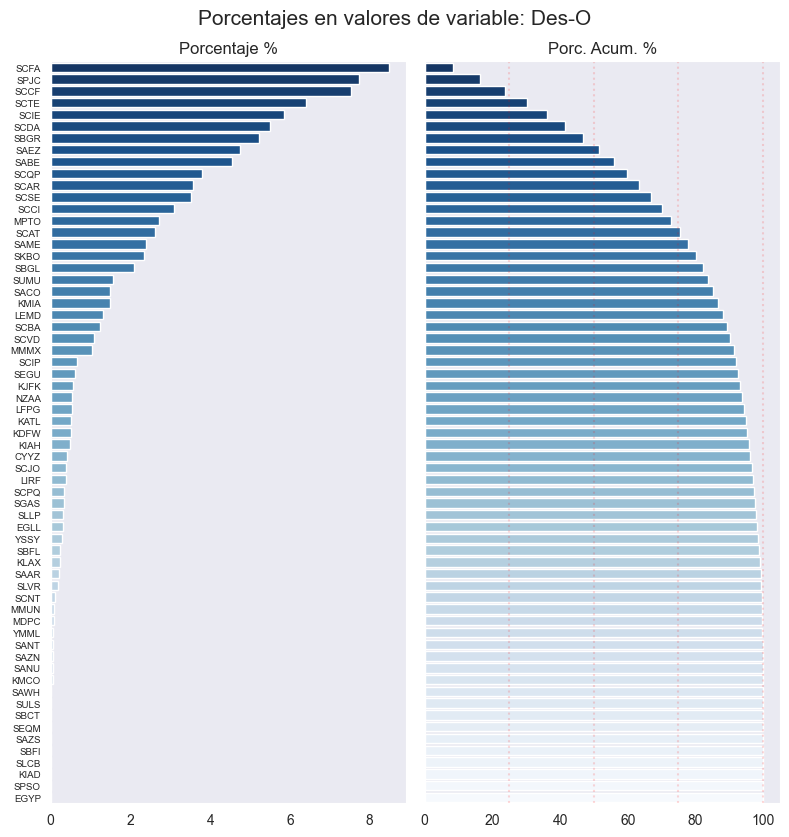

---------------------------------------------------
Variable:  SIGLADES
Valores con mas registros:
       SIGLADES  cantidad  Porc.%  Acum.%
0  Buenos Aires      6335    9.29    9.29
1   Antofagasta      5786    8.48   17.78
2          Lima      5270    7.73   25.51
3        Calama      5146    7.54   33.05
4  Puerto Montt      4357    6.39   39.45
5    Concepcion      3993    5.85   45.30
Valores con menos registros:
          SIGLADES  cantidad  Porc.%  Acum.%
58      Pisco-Peru         1     0.0   100.0
59  Puerto Stanley         1     0.0   100.0
60      Cochabamba         1     0.0   100.0
61      Washington         1     0.0   100.0


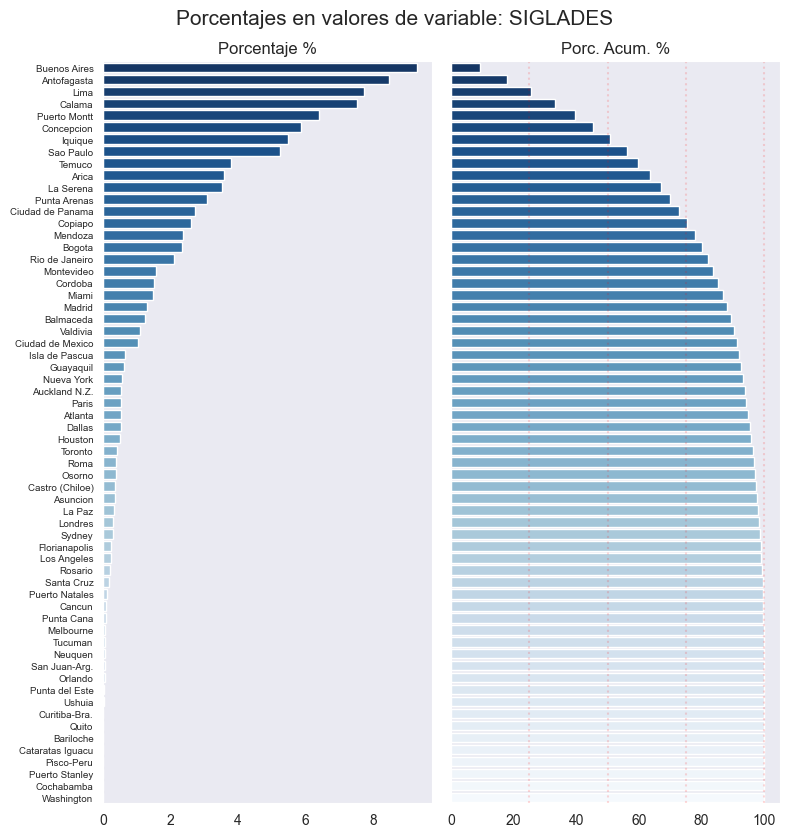

---------------------------------------------------
Variable:  Emp-I
Valores con mas registros:
  Emp-I  cantidad  Porc.%  Acum.%
0   LAN     37611   55.14   55.15
1   SKU     14298   20.96   76.11
2   TAM      3049    4.47   80.58
3   ARG      1949    2.86   83.44
4   CMP      1850    2.71   86.15
5   LAW      1574    2.31   88.46
Valores con menos registros:
   Emp-I  cantidad  Porc.%  Acum.%
26   LXP         9    0.01   99.99
27   LPE         4    0.01  100.00
28   DSM         2    0.00  100.00
29   LNE         1    0.00  100.00


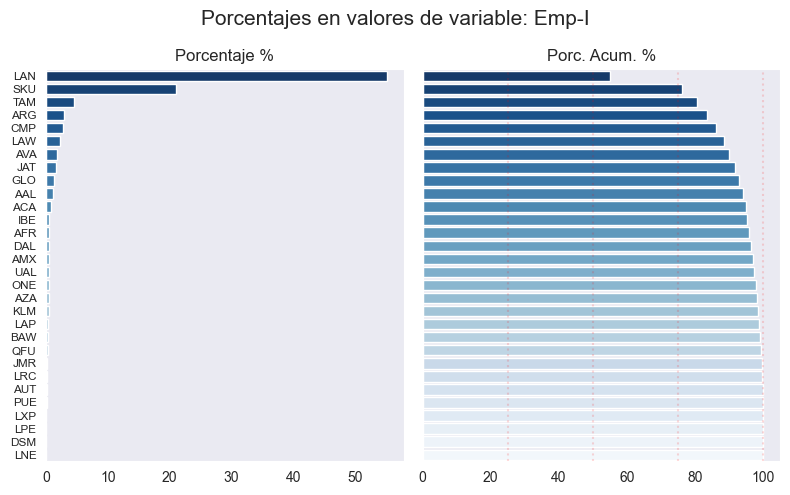

---------------------------------------------------
Variable:  Emp-O
Valores con mas registros:
  Emp-O  cantidad  Porc.%  Acum.%
0   LAN     20988   30.77   30.78
1   LXP     14558   21.34   52.13
2   SKU     14298   20.96   73.10
3   TAM      3046    4.47   77.57
4   ARG      1946    2.85   80.42
5   CMP      1850    2.71   83.13
Valores con menos registros:
   Emp-O  cantidad  Porc.%  Acum.%
28   PUE        49    0.07   99.97
29   56R        17    0.02   99.99
30   48O        10    0.01  100.00
31   TPU         2    0.00  100.00


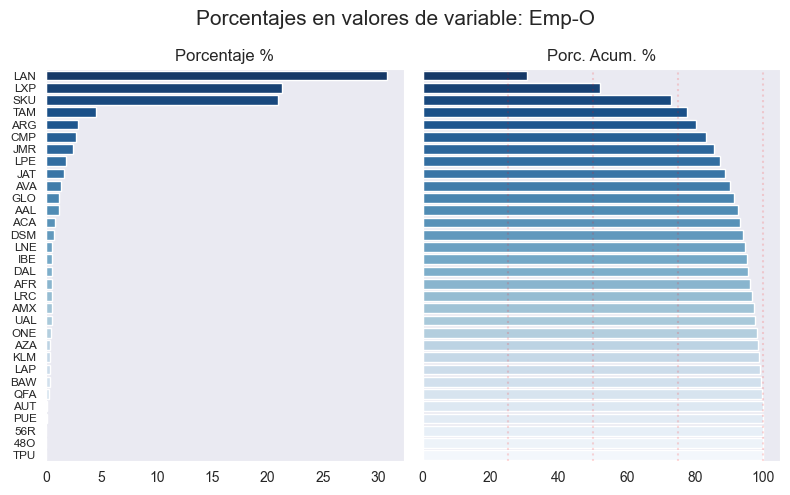

---------------------------------------------------
Variable:  OPERA
Valores con mas registros:
                   OPERA  cantidad  Porc.%  Acum.%
0            Grupo LATAM     40892   59.95   59.96
1            Sky Airline     14298   20.96   80.93
2  Aerolineas Argentinas      1949    2.86   83.79
3               Copa Air      1850    2.71   86.50
4   Latin American Wings      1674    2.45   88.95
5                Avianca      1152    1.69   90.64
Valores con menos registros:
                       OPERA  cantidad  Porc.%  Acum.%
19            Qantas Airways       195    0.29   99.69
20                     Lacsa        92    0.13   99.82
21                   Austral        74    0.11   99.93
22  Plus Ultra Lineas Aereas        49    0.07  100.00


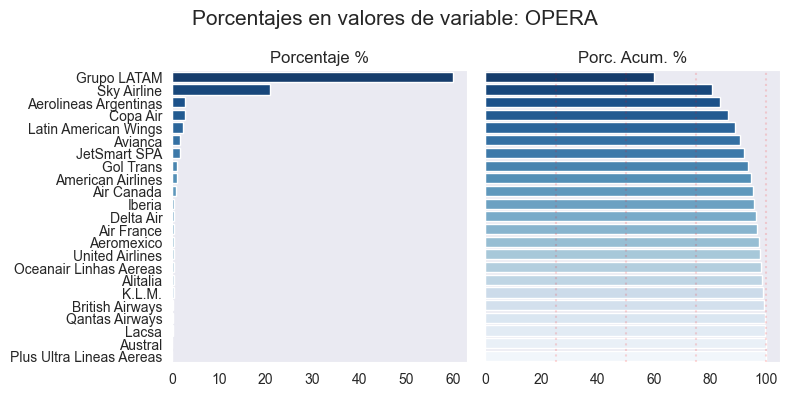

---------------------------------------------------
Variable:  DIANOM
Cantidad de registros por valor:
      DIANOM  cantidad  Porc.%  Acum.%
0    Viernes     10292   15.09   15.09
1     Jueves     10251   15.03   30.12
2      Lunes     10131   14.85   44.97
3    Domingo      9796   14.36   59.33
4  Miercoles      9722   14.25   73.58
5     Martes      9662   14.17   87.75
6     Sabado      8352   12.25  100.00


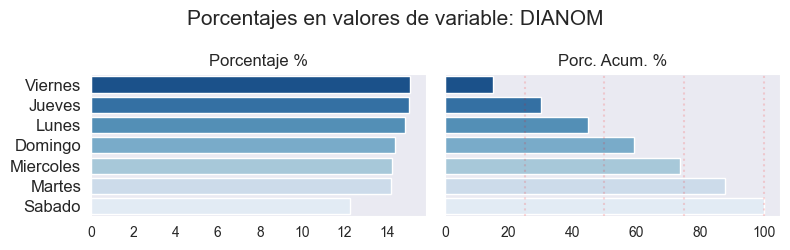

---------------------------------------------------
Variable:  MESNOM
Cantidad de registros por valor:
       MESNOM  cantidad  Porc.%  Acum.%
0   Diciembre      6356    9.32    9.32
1       Enero      6108    8.96   18.28
2   Noviembre      6080    8.91   27.19
3     Octubre      6032    8.84   36.03
4       Julio      5992    8.79   44.82
5      Agosto      5744    8.42   53.24
6   Setiembre      5610    8.23   61.47
7     Febrero      5561    8.15   69.62
8       Marzo      5482    8.04   77.66
9        Mayo      5240    7.68   85.34
10      Abril      5020    7.36   92.70
11      Junio      4981    7.30  100.00


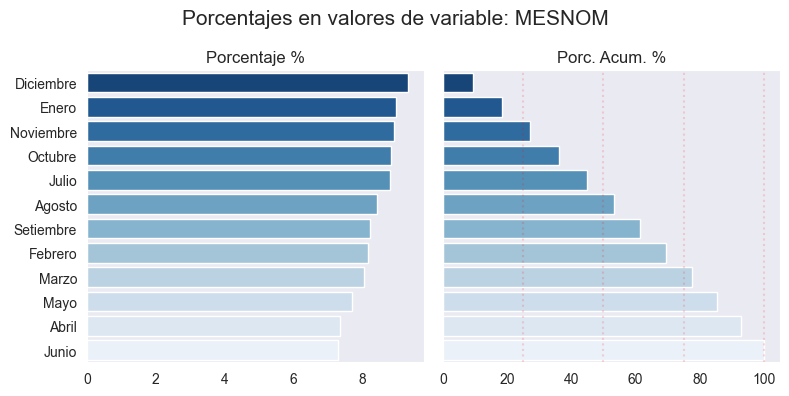

In [197]:
# Ver detalle de cada variable categorica

# definir funcion para graficar
def graf_cat(datacat,variable):
    
    # separador
    print('---------------------------------------------------')
    sns.set_style("dark") # seteo de tema de fondo
    
    # Titulo
    print('Variable: ',variable)
    
    conteo = datacat[[variable]] # seleccionar variable
    conteo["cantidad"] = 1   # variable auxiliar
    conteo = conteo.groupby(variable).agg(np.sum).sort_values("cantidad",ascending=False).reset_index() # conteo de valores por grupo
    conteo["Porc.%"] = np.round(100.0*conteo["cantidad"]/np.sum(conteo["cantidad"]),2) # calculo de densidad
    conteo["Acum.%"] = np.round(100.0*conteo["Porc.%"].cumsum()/conteo["Porc.%"].sum(),2) # calculo de acumulado     
    
    # Mostrar lista/tabla de cantidad de registros por valor unico en la variable
    if(conteo.shape[0] > 15):
        print('Valores con mas registros:')
        print(conteo.head(6))
        print('Valores con menos registros:')
        print(conteo.tail(4))
    else:
        print('Cantidad de registros por valor:')
        print(conteo)
    
    cantidad = conteo.shape[0] # cantidad de registros en dataframe agrupado
    
    # Determinar aspectos de tamaño de la figura y tamaño de letra
    if(cantidad < 10):
        figy = 2.5
        fontsize = 12.0
    elif(cantidad < 25):
        figy = 4.0
        fontsize = 10.0
    elif(cantidad < 45):
        figy = 5.0
        fontsize = 8.5
    elif(cantidad < 60):
        figy = 7.5
        fontsize = 8.0
    else:
        figy = 8.5 
        fontsize = 7.0   
    
    # En caso tenga al menos 5 valores unicos se genera la grafica
    if(cantidad > 4):
        
        # Figura
        fig, ax = plt.subplots(1,2, sharey=True, figsize=(8,figy))
        fig.suptitle('Porcentajes en valores de variable: ' + str(variable),fontsize=15)
        
        # Grafica izquierda - Densidad
        ax[0].set_title('Porcentaje %',fontsize=12)
        x1 = sns.barplot(conteo,x="Porc.%",y=variable,palette="Blues_r",ax=ax[0])
        x1.set_yticklabels(conteo[variable], size = fontsize)
        
        ax[0].set_xlabel("")
        ax[0].set_ylabel("")
        
        # Grafica derecha - Densidad Acumulada (Distribucion)
        ax[1].set_title('Porc. Acum. %',fontsize=12)
        x2 = sns.barplot(conteo,x="Acum.%",y=variable,palette="Blues_r",ax=ax[1])
        x2.set_yticklabels(conteo[variable],size=fontsize)
        
        # Agregar lineas de referencia
        ax[1].axvline(x=25, color='r', label='25%',linestyle="dotted",alpha=0.15)
        ax[1].axvline(x=50, color='r', label='50%',linestyle="dotted",alpha=0.15)
        ax[1].axvline(x=75, color='r', label='75%',linestyle="dotted",alpha=0.15)
        ax[1].axvline(x=100, color='r', label='100%',linestyle="dotted",alpha=0.15)
        
        ax[1].set_xlabel("")
        ax[1].set_ylabel("")
        
        fig.tight_layout()
        plt.show()
  
# Graficar
graf_cat(datacat,"TIPOVUELO")
graf_cat(datacat,"Ori-I")
graf_cat(datacat,"Ori-O")
graf_cat(datacat,"SIGLAORI")
graf_cat(datacat,"Des-I")
graf_cat(datacat,"Des-O")
graf_cat(datacat,"SIGLADES")
graf_cat(datacat,"Emp-I")
graf_cat(datacat,"Emp-O")
graf_cat(datacat,"OPERA")
graf_cat(datacat,"DIANOM")
graf_cat(datacat,"MESNOM")


<b>Variables Continuas

Previo a realizar el analisis, agregamos 2 variables, los cuales son:
- `dif_min` : Diferencia entre `Fecha-O` y `Fecha-I`, mide el retraso (en minutos) entre la hora que ocurrió respecto de la planificada
- `I_VLO` : Variable indicadora que indica cuando `Vlo-O` y `Vlo-1` son diferentes. (`Valor=1` cuando no coinciden. 0 en otro caso) 

In [191]:
# Variable de retraso de vuelo
data["dif_min"] = (data["Fecha-O"] - data["Fecha-I"]).dt.total_seconds()/60.0 # total de segundos convertir a minutos
data["dif_min"] = pd.to_numeric(data["dif_min"], errors="coerce",downcast="integer") # convertir a tipo entero

# Variable de indicador entre numero de vuelo
data["I_VLO"] = 1*(data["Vlo-O"] != data["Vlo-I"])

In [192]:
# seleccionar variables continuas
datacon = data.select_dtypes(exclude=["object"]).copy()
datacon.head(8)

,Fecha-I,Vlo-I,Fecha-O,Vlo-O,DIA,MES,AÑO,dif_min,I_VLO
0,2017-01-01 23:30:00,226,2017-01-01 23:33:00,226,1,1,2017,3,0
1,2017-01-02 23:30:00,226,2017-01-02 23:39:00,226,2,1,2017,9,0
2,2017-01-03 23:30:00,226,2017-01-03 23:39:00,226,3,1,2017,9,0
3,2017-01-04 23:30:00,226,2017-01-04 23:33:00,226,4,1,2017,3,0
4,2017-01-05 23:30:00,226,2017-01-05 23:28:00,226,5,1,2017,-2,0
5,2017-01-06 23:30:00,226,2017-01-07 00:04:00,226,7,1,2017,34,0
6,2017-01-07 23:30:00,226,2017-01-07 23:25:00,226,7,1,2017,-5,0
7,2017-01-08 23:30:00,226,2017-01-08 23:25:00,226,8,1,2017,-5,0


In [193]:
# Descripcion general de los datos
datacon.describe()

,Vlo-I,Vlo-O,DIA,MES,AÑO,dif_min,I_VLO
count,68206.000000,68206.000000,68206.000000,68206.000000,68206.000000,68206.000000,68206.000000
mean,969.827288,967.421092,15.714790,6.622585,2017.000029,9.110855,0.001495
std,2029.024762,2026.193621,8.782886,3.523321,0.005415,19.313387,0.038643
min,1.000000,1.000000,1.000000,1.000000,2017.000000,-14.000000,0.000000
25%,150.000000,150.000000,8.000000,3.000000,2017.000000,-1.000000,0.000000
50%,300.000000,300.000000,16.000000,7.000000,2017.000000,4.000000,0.000000
75%,632.000000,637.500000,23.000000,10.000000,2017.000000,12.000000,0.000000
max,9956.000000,9956.000000,31.000000,12.000000,2018.000000,161.000000,1.000000


---------------------------------------------------


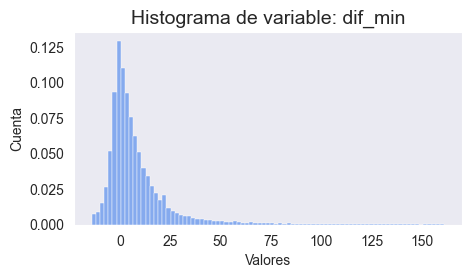

---------------------------------------------------


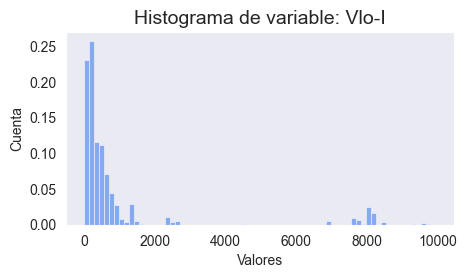

---------------------------------------------------


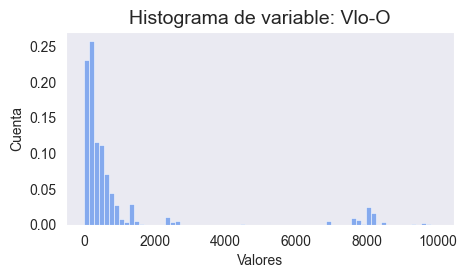

---------------------------------------------------
Variable:  I_VLO
Cantidad de registros por valor:
   I_VLO  cantidad  Porc.%  Acum.%
0      0     68104   99.85   99.85
1      1       102    0.15  100.00
---------------------------------------------------


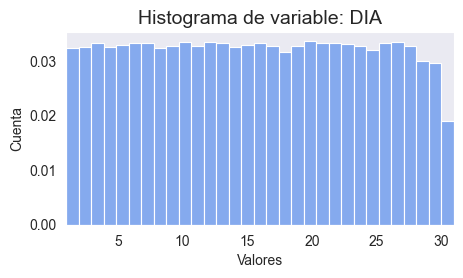

---------------------------------------------------
Variable:  DIA
Valores con mas registros:
   DIA  cantidad  Porc.%  Acum.%
0   20      2290    3.36    3.36
1   27      2286    3.35    6.71
2   12      2284    3.35   10.06
3   10      2283    3.35   13.41
4    6      2275    3.34   16.75
5   22      2272    3.33   20.08
6   13      2272    3.33   23.41
7    3      2271    3.33   26.74
8   16      2268    3.33   30.07
9   21      2267    3.32   33.39
Valores con menos registros:
    DIA  cantidad  Porc.%  Acum.%
21    2      2223    3.26   72.80
22   14      2221    3.26   76.06
23    4      2215    3.25   79.31
24    8      2213    3.24   82.55
25    1      2208    3.24   85.79
26   25      2179    3.19   88.98
27   18      2160    3.17   92.15
28   29      2044    3.00   95.15
29   30      2020    2.96   98.11
30   31      1290    1.89  100.00
---------------------------------------------------


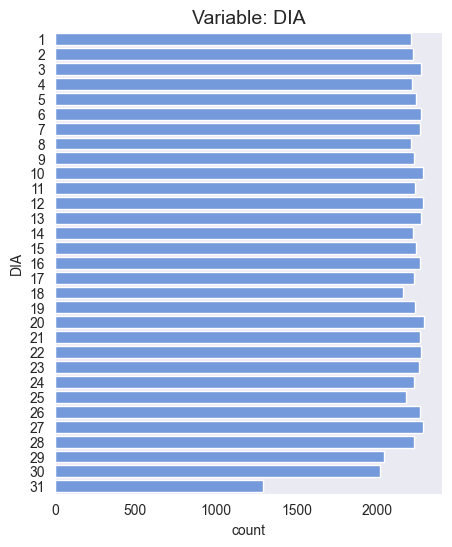

---------------------------------------------------


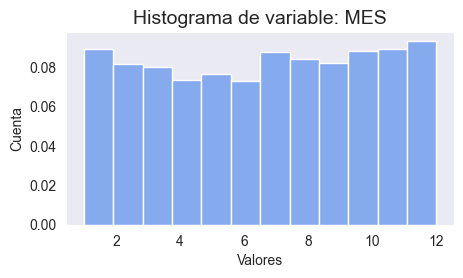

---------------------------------------------------
Variable:  MES
Cantidad de registros por valor:
    MES  cantidad  Porc.%  Acum.%
0    12      6356    9.32    9.32
1     1      6108    8.96   18.28
2    11      6080    8.91   27.19
3    10      6032    8.84   36.03
4     7      5992    8.79   44.82
5     8      5744    8.42   53.24
6     9      5610    8.23   61.47
7     2      5561    8.15   69.62
8     3      5482    8.04   77.66
9     5      5240    7.68   85.34
10    4      5020    7.36   92.70
11    6      4981    7.30  100.00
---------------------------------------------------


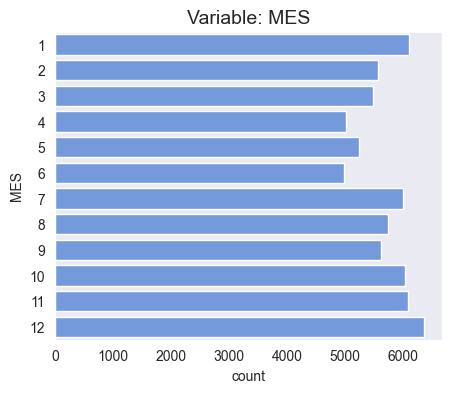

---------------------------------------------------
Variable:  AÑO
Cantidad de registros por valor:
    AÑO  cantidad  Porc.%  Acum.%
0  2017     68204   100.0   100.0
1  2018         2     0.0   100.0


In [198]:
# Analizar variables continuas

# funcion para mostrar distribucion
def graf_cont(datos,variable,figx=5,figy=2.5,tipo=1,min=None,max=None,bins=None):
    
    # separador
    print('---------------------------------------------------')
    
    sns.set_style("dark") # seteo de tema de fondo
    
    # Histograma
    if(tipo==1):
        
        plt.figure(figsize=(figx,figy)) # grafica
        
        if(min and max and bins):
            ##plt.hist(datos[variable],bins=bins,color="cornflowerblue")
            sns.histplot(datos,x=variable,bins=bins,stat="proportion",color="cornflowerblue")
            plt.xlim([min,max])
        elif(bins):
            ##plt.hist(datos[variable],bins=bins,color="cornflowerblue")
            sns.histplot(datos,x=variable,bins=bins,stat="proportion",color="cornflowerblue")
        else:
            ##plt.hist(datos[variable],color="royalblue")
            sns.histplot(datos,x=variable,stat="proportion",color="cornflowerblue")
        plt.title('Histograma de variable: ' + str(variable),fontsize=14)
        plt.xlabel("Valores",fontsize=10)
        plt.ylabel('Cuenta',fontsize=10)
        plt.show()
    
    # Conteo de valores unicos en tabla - no grafica
    elif(tipo==2):
        
        print('Variable: ',variable)
        
        # Realizar el conteo de cada valor unico en la tabla y obtener tanto porcentaje (%) como el acumulado
        conteo = datos[[variable]]
        conteo["cantidad"] = 1
        conteo = conteo.groupby(variable).agg(np.sum).sort_values("cantidad",ascending=False).reset_index()
        conteo["Porc.%"] = np.round(100.0*conteo["cantidad"]/np.sum(conteo["cantidad"]),2) # calculo de densidad
        conteo["Acum.%"] = np.round(100.0*conteo["Porc.%"].cumsum()/conteo["Porc.%"].sum(),2) # calculo de acumulado     
        
        # Imprimir tabla de conteo de registros por cada valor unico de la variable
        if(conteo.shape[0] > 20):
            print('Valores con mas registros:')
            print(conteo.head(10))
            print('Valores con menos registros:')
            print(conteo.tail(10))
        else:
            print('Cantidad de registros por valor:')
            print(conteo)
    
    # grafica de barras segun conteo    
    elif(tipo==3):
        
        plt.figure(figsize=(figx,figy))
        b = sns.countplot(datos,y=variable,color="cornflowerblue")
        plt.ylabel(variable,fontsize=10)
        plt.title("Variable: " + str(variable),fontsize=14)
        plt.show()

# Graficar-Calcular
graf_cont(datacon,"dif_min",tipo=1,bins=85)
graf_cont(datacon,"Vlo-I",tipo=1,bins=70)
graf_cont(datacon,"Vlo-O",tipo=1,bins=70)
graf_cont(datacon,"I_VLO",tipo=2)
graf_cont(datacon,"DIA",min=1,max=31,bins=31,tipo=1)
graf_cont(datacon,"DIA",min=1,tipo=2)
graf_cont(datacon,"DIA",figy=6,tipo=3)
graf_cont(datacon,"MES",min=0,max=13,bins=12,tipo=1)
graf_cont(datacon,"MES",tipo=2)
graf_cont(datacon,"MES",figy=4,tipo=3)
graf_cont(datacon,"AÑO",tipo=2)
